In [14]:
from numpy import array
from numpy import hstack

In [15]:
# Reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_bed3c3c1607144b69077066929a4f961 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='APIkey',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_bed3c3c1607144b69077066929a4f961.get_object(Bucket='ibmhackchallenge2020-donotdelete-pr-n0hs7jsuxlpv6c',Key='integrated_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df= pd.read_csv(body)
df.head()


,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction,end_date,maxtempC,windGustKmph,DewPointC,windChillC,humidity,precipMM,pressure,LV ActivePower
0,5.311336,416.328908,259.994904,2018-01-01 00:00:00,10.0,11.125,2.208333,6.333333,69.916667,0.0,1017.625,380.047791
1,5.672167,519.917511,268.641113,2018-01-01 00:10:00,10.0,11.125,2.208333,6.333333,69.916667,0.0,1017.625,453.769196
2,5.216037,390.900016,272.564789,2018-01-01 00:20:00,10.0,11.125,2.208333,6.333333,69.916667,0.0,1017.625,306.376587
3,5.659674,516.127569,271.258087,2018-01-01 00:30:00,10.0,11.125,2.208333,6.333333,69.916667,0.0,1017.625,419.645905
4,5.577941,491.702972,265.674286,2018-01-01 00:40:00,10.0,11.125,2.208333,6.333333,69.916667,0.0,1017.625,380.650696


In [2]:
df.drop("end_date", axis = 1, inplace = True)

In [3]:
df.shape

(50530, 11)

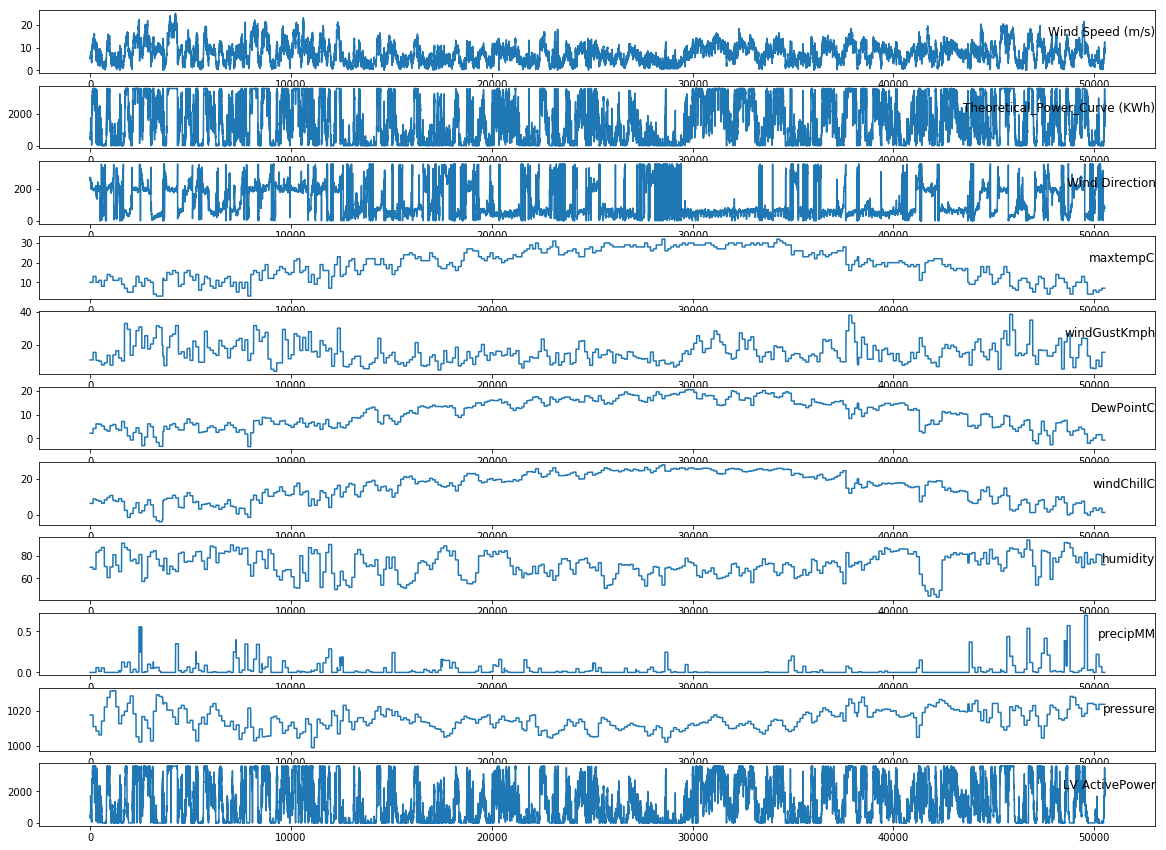

In [11]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
i = 1
# plot each column
pyplot.figure(figsize=(20, 15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [12]:
train_data = df.values[:40000, :]
test_data = df.values[40000:, :]

In [13]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))

scaled_train_data = sc.fit_transform(train_data)
scaled_test_data = sc.transform(test_data)

In [20]:
n_steps_in = 144
n_steps_out = 72
X, y = split_sequences(scaled_train_data, n_steps_in=n_steps_in, n_steps_out=n_steps_out)

In [21]:
X.shape, y.shape

((39786, 144, 10), (39786, 72))

In [22]:
n_features = X.shape[2]

In [29]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout

In [31]:
# define model
model = Sequential()

model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(n_steps_out))

In [32]:
model.compile(optimizer='adam', loss='mse')

In [34]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
  
    def on_batch_end(self, batch, logs = {}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

In [35]:
# define the checkpoint
filepath = "model_with_2lstm100_1dense128_dropout0.25_layers.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, history]

In [37]:
model_history = model.fit(X, y, batch_size=72, epochs = 100, validation_split=0.15, shuffle = False, verbose = 1, callbacks=callbacks_list)

Train on 33818 samples, validate on 5968 samples
Epoch 1/100
   72/33818 [..............................] - ETA: 34:03:46 - loss: 0.8373

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy of 1000units 7 layers
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()